<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Загрузка-и-предобработка-данных" data-toc-modified-id="Загрузка-и-предобработка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Загрузка и предобработка данных</a></span></li><li><span><a href="#Подготовка-функций" data-toc-modified-id="Подготовка-функций-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Подготовка функций</a></span></li><li><span><a href="#Расчет-статистических-данных" data-toc-modified-id="Расчет-статистических-данных-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Расчет статистических данных</a></span></li><li><span><a href="#Формирование-сообщения-с-отчетом" data-toc-modified-id="Формирование-сообщения-с-отчетом-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Формирование сообщения с отчетом</a></span></li></ul></div>

# Недельная статистика чата в Telegram

## Загрузка и предобработка данных 

In [1]:
# !pip install emoji
# !pip install pymorphy2
# nltk.download('punkt')
# nltk.download('stopwords')

In [1]:
import pandas as pd
import numpy as np
import json
from datetime import datetime, timedelta, date
import datetime as dt
import re
import emoji
import nltk
from nltk import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from pymorphy2 import MorphAnalyzer
from sqlalchemy import create_engine
pd.options.display.max_colwidth = 150
pd.set_option('chained_assignment', None)

Создаем цикл, который поочередно считывает выгруженные из чата json-файлы за каждый день недели, конвертирует их в датафреймы и соединяет в одну таблицу.

In [ ]:
df = pd.DataFrame()
for day in range(7):
    with open(f'C:/.../ChatExport_{str(date.today() - timedelta(days=day))}/result.json',
          encoding = 'UTF-8') as file:
        data = json.load(file)
    messages = pd.json_normalize(data,
                                record_path='messages',
                                meta='id',
                                record_prefix='messages-',
                                errors="ignore")
    messages = messages[messages['messages-type'] == 'message']
    messages = messages[messages['messages-from_id'] != 'user752259676']
    messages = messages[messages['messages-forwarded_from'].isna()]
    messages = messages[['messages-date', 'messages-from', 'messages-from_id', 'messages-text']]
    messages['messages-date'] = pd.to_datetime(messages['messages-date'], format='%Y-%m-%d')
    messages['messages-date'] = messages['messages-date'].apply(lambda x: dt.date(x.year,x.month,x.day))
    date_filter = date.today() - timedelta(days=day+1)
    messages = messages[messages['messages-date'] == date_filter]
    df = pd.concat([df, messages], ignore_index=True, sort=False)
    
df

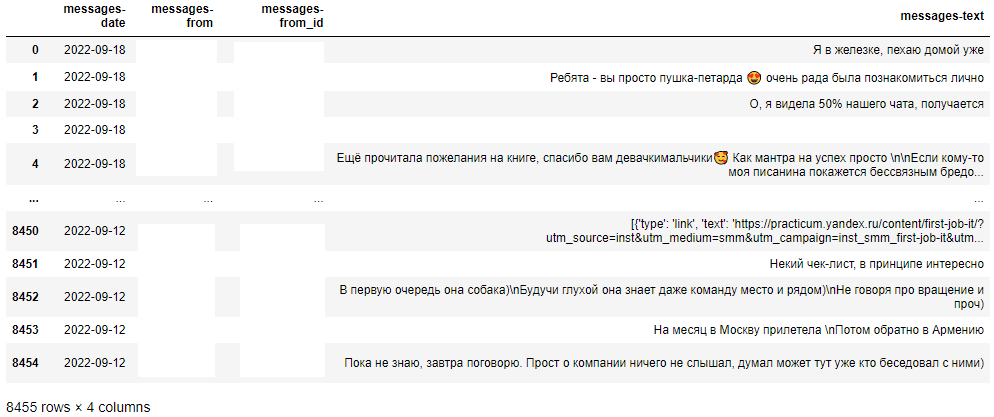

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8455 entries, 0 to 8454
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   messages-date     8455 non-null   object
 1   messages-from     8455 non-null   object
 2   messages-from_id  8455 non-null   object
 3   messages-text     8455 non-null   object
dtypes: object(4)
memory usage: 264.3+ KB


Задаем начало и конце недельного периода

In [4]:
yest_fmt = (date.today() - timedelta(days=1)).strftime(format = '%d-%m-%Y')
week_before = (date.today() - timedelta(days=7)).strftime(format = '%d-%m-%Y')
print(yest_fmt, week_before)

18-09-2022 12-09-2022


Создадаем список с юзернеймами всех участников группы.

In [5]:
username_dict = {
                'user391639940': '@Tiny_Ton', ...
                }

## Подготовка функций

Для нахождения сообщений с матом.

In [6]:
def top_swearers(row):
    regex = r'\b(?:(?:а|сни|о|ни ?)?[хзкб]у[ й#*@]?(?:ца|е|е[вцн]|ю|ет[уаь]|н[яюе]|ел|л[ие]\b|я(?: [тс]ебе)?| [твн]ам| [тс]ебе))(?!ть)|(?:пи?[з\*][дж](?:ец|а|и[тш]ь?|у|ю|или?|е|ов|ят|ища))|(?<![лрт])(?:е[б\*]а[нл](?:ат[а|ом|ами]?|ько|))|(?<![вдрнч])(?:е[б\*](?:[уеа]т[ь]?|у(?:ч|чк.)?\b|цч|и|(?: тв| ва|ы)))|\b(?:на)?[хз]уй|(?:сук(?:[аи]|ой|аэл(?:ь|ем?)(?:чик)?|ами?)?)\b|(?<![рау])(?:ука)?(?:бл[яэ][тд]?(?:ью?|я*|ей|ями?)?)(?!н)|(?<!у)(?:муда?[^р ])|н[еи] ип(?:[уе]т?)'
    findall = re.findall(regex, str(row), flags = re.IGNORECASE)
    if findall:
        result = len(findall)
    else:
        result = 0
    return result

Для подсчета длины сообщений (очищаем от эмоджи и разбиваем на слова).

In [7]:
def words(row):
    deEmoj = emoji.demojize(str(row))
    regex = r":[a-z_]*:|{?'type'(?:\: ?)*|{?'code'(?:\: ?)*|{?'text'(?:\: ?)*|'|{|}"
    clean_text = re.sub(regex, '', deEmoj)
    strip = clean_text.strip()
    regex = r'\b[а-яё-]+\b'
    words_count = re.findall(regex, strip, flags = re.IGNORECASE)
    return len(words_count)

Применяем все функции.

In [ ]:
df['username'] = df['messages-from_id'].apply(lambda x: username_dict.get(x, '--'))
df['swearer'] = df['messages-text'].apply(top_swearers)
df['words'] = df['messages-text'].apply(words)
df.sample(10)

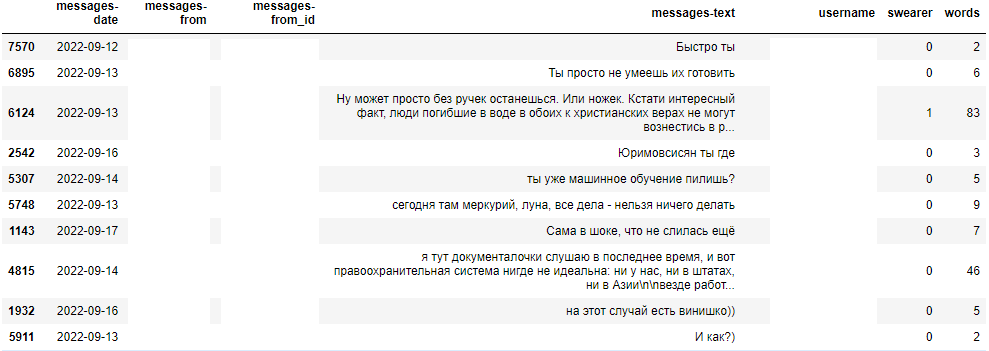

## Расчет статистических данных

Определяем топ самых разговорчивых участников, а также считаем количество слов, в том числе матных.

In [ ]:
df_grp = (
          df.groupby(['messages-from', 'messages-from_id', 'username'])
          .agg({'messages-text': 'count', 'swearer': 'sum', 'words': 'sum'})
          .sort_values(by='messages-text', ascending=False).reset_index()
         )
most_talky = df_grp.head()
most_talky

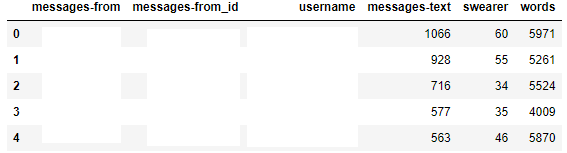

Для ведения статистики о том, сколько раз человек входил в недельные топы, необходимо вести базу данных, в которую каждую неделю добавляется таблица наподобие той, которая ниже.

In [ ]:
most_talky_for_db = most_talky.copy()

# проставляем место участника в топе
most_talky_for_db['rank'] = most_talky_for_db.index + 1

# добавляем столбец с датой начала недели
most_talky_for_db['start_of_week'] = date.today() - timedelta(days=7)

# приводим названия столбцов к удобному виду
most_talky_for_db = most_talky_for_db.rename(columns={'messages-from': 'from_nick',
                                                      'messages-from_id': 'from_id'})

most_talky_for_db = most_talky_for_db[['start_of_week', 'from_nick',
                                       'from_id', 'username', 'rank']]

most_talky_for_db

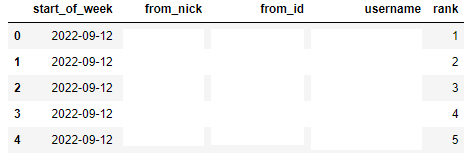

Создаем подключение к базе данных

In [14]:
engine = create_engine('sqlite:///C:/.../tg_chat.db')
engine.connect()

Для предотвращения возможного дублирования информации предусмотрим удаление из базы данных строк за последнюю неделю

In [15]:
query = f'''DELETE FROM weekly_tops 
                   WHERE start_of_week = '{most_talky_for_db['start_of_week'][0]}'
            '''
engine.execute(query)

In [16]:
most_talky_for_db.to_sql(name = 'weekly_tops', con = engine, if_exists = 'append', index = False)

In [17]:
def select(sql,engine=engine):
    return pd.read_sql(sql,engine)

Создаем список юзернеймов тех, кто вошел в топ на этой неделе. Затем в базе данных найдем количество вхождений этих юзернеймов в топы за всю историю.

In [ ]:
winners = list(most_talky_for_db['from_nick'].unique())
winners = str(winners)

In [ ]:
sql = f'''
select from_nick, count(rank) tops
from weekly_tops
where from_nick in ({winners[1:-1]})
group by from_nick
'''

df_sql = select(sql)
df_sql

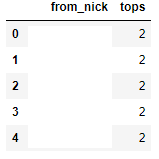

Топ самых неразговорчивых.

In [ ]:
most_reticent = df_grp.tail().sort_values(by='messages-text')
most_reticent

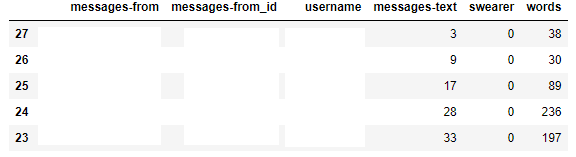

Определяем топ-10 самых частых слов для каждого юзера.

In [21]:
# очищаем от эмоджи и знаков препинания
def full_clean_text(row):
    deEmoj = emoji.demojize(str(row))
    regex = r"""[—'{}\\:;,.()\[\]a-z@\/?\+!0-9&_=#$%^*~\"…«»-]+|\n"""
    clean_text = re.sub(regex, ' ', deEmoj, flags = re.IGNORECASE)
    return clean_text

Задаем список стоп-слов.

In [25]:
morph = MorphAnalyzer()
russian_stopwords = stopwords.words("russian")
russian_stopwords.extend(['это', 'еще', 'очень', 'вообще', 'просто', 'кстати', 'вроде',
                          'хз', 'тебе', 'ок', 'пока', 'типа', 'какие', 'кажется',
                          'сегодня', 'завтра', 'поэтому', 'такой', 'вчера', 'норм',
                          'спасибо', 'блин', 'ага', 'ща', 'прям', 'который', 'весь',
                          'свой', 'тип', 'мой', 'твой', 'наш', 'ваш', 'самый', 'ой'])

Для каждого участника, вошедшего в топ-5, создаем список наиболее частых слов.

In [26]:
def author_clean_text(row):
    temp_df = df[df['messages-from'] == row]
    temp_df['clean_text'] = temp_df['messages-text'].apply(full_clean_text)
    clean_text = []
    for message in temp_df['clean_text']:
        token = list(map(lambda x: morph.normal_forms(x.strip())[0], message.lower().split()))
        clean_text.extend(token)
    clean_text = ' '.join(clean_text)
    clean_text = clean_text.replace('ё', 'е')
    text_tokens = word_tokenize(clean_text)
    text_tokens = nltk.Text(text_tokens)
    words_frequency_wo_sw = [word for word in text_tokens if not word in russian_stopwords]
    words_frequency_wo_sw = FreqDist(words_frequency_wo_sw)
    top_10_words = words_frequency_wo_sw.most_common(10)
    top_10_words_str = ''
    for i in range(len(top_10_words)):
        top_10_words_str += top_10_words[i][0] + ', '
    return top_10_words_str[:-2]

In [ ]:
most_talky['most_frequent_words'] = most_talky['messages-from'].apply(author_clean_text)
most_talky

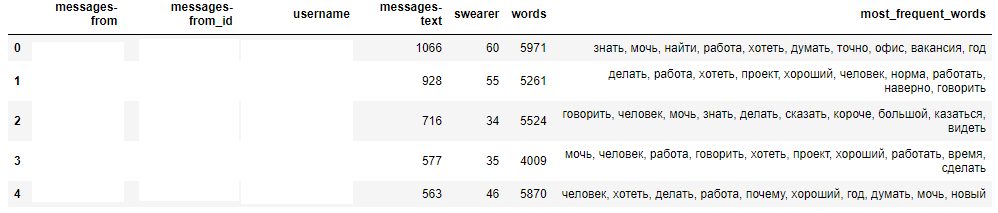

Соединяем две таблицы.

In [ ]:
most_talky = most_talky.merge(df_sql, left_on='messages-from', right_on='from_nick').drop('from_nick', axis=1)
most_talky

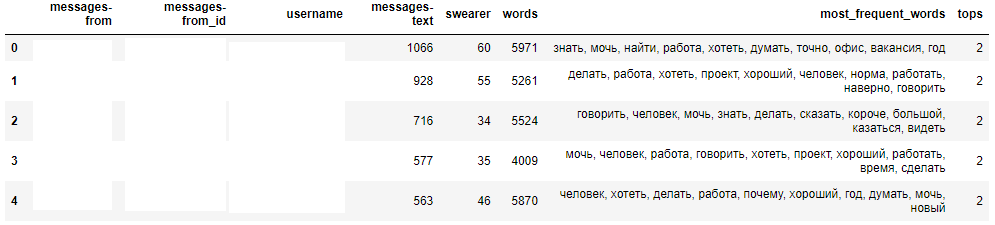

Определяем звание и род глагола.

In [29]:
if most_talky['messages-from'][0] in (
    список ников девушек
    ):
    title = 'Госпожа'
    was = 'Была'
else:
    title = 'Господин'
    was = 'Был'

Определяем форму слова 'раз'.

In [30]:
if most_talky.iloc[0][7] % 100 in (11, 12, 13, 14):
    wordform = 'раз'
else:
    if most_talky.iloc[0][7] % 10 in (2, 3 ,4):
        wordform = 'раза'   
    else:
        wordform = 'раз'

## Формирование сообщения с отчетом

In [ ]:
print(f"""⚡️⚡️⚡️

Недельный топ чата **"{data['name']}"**.

Статистика за период с {week_before} по {yest_fmt}.
   
Звание **"{title} словоохотливость недели"**
заслуженно получает:

3...

2...

1...

❗️❗️❗️ **{most_talky.iloc[0][0]}** ({most_talky.iloc[0][2]}) ❗️❗️❗️

🎉 🎊 **ПОЗДРАВЛЯЕМ** 🍾 👏

**Статистика по победителю**:
__Сообщений__ — {most_talky.iloc[0][3]} 👍
__Слов__ — {most_talky.iloc[0][5]} (из них матных — {most_talky.iloc[0][4]}, или {round(most_talky.iloc[0][4]/most_talky.iloc[0][5]*100, 2)}%) 💪
__Самые частые слова__ — {most_talky.iloc[0][6]} ☝️
__{was} в недельном топе уже {most_talky.iloc[0][7]} {wordform}!__

**В топ-5 также вошли**:""")

for i in range(1, 5):
    print(f"""**{most_talky.iloc[i][0]}** ({most_talky.iloc[i][2]})
__Сообщений__ — {most_talky.iloc[i][3]},
__Слов__ — {most_talky.iloc[i][5]} (из них матных — {most_talky.iloc[i][4]}, или {round(most_talky.iloc[i][4]/most_talky.iloc[i][5]*100, 2)}%),
__Самые частые слова__ — {most_talky.iloc[i][6]},
__Был(-а) в топе раз__ — {most_talky.iloc[i][7]}.
""")

print("""Топ в категории **'Простите, я просто почитать'**:""")
for i in range(len(most_reticent)):
    print(f'{i+1}) **{most_reticent.iloc[i][0]}** ({most_reticent.iloc[i][2]}) (сообщений: {most_reticent.iloc[i][3]})')

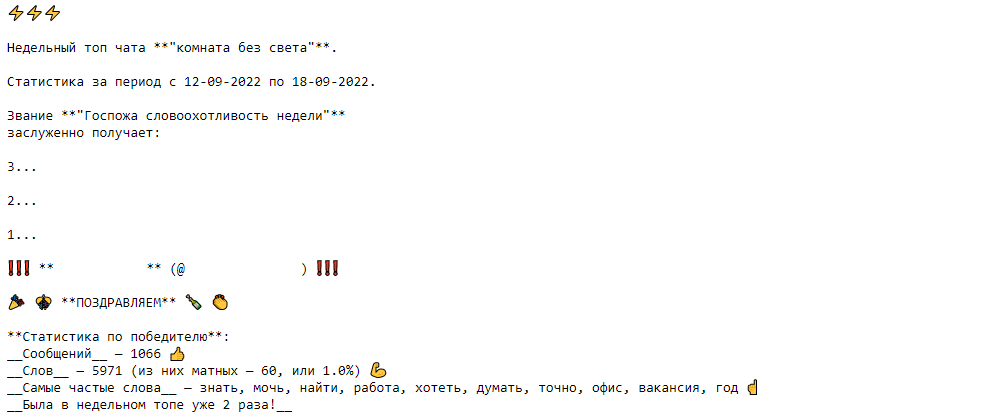

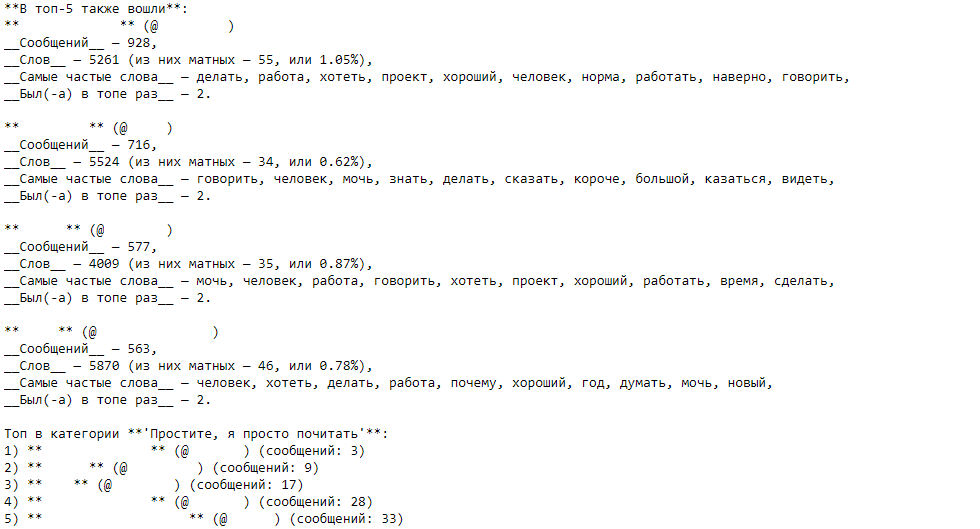

Так собщение выглядит в телеграм-чате:

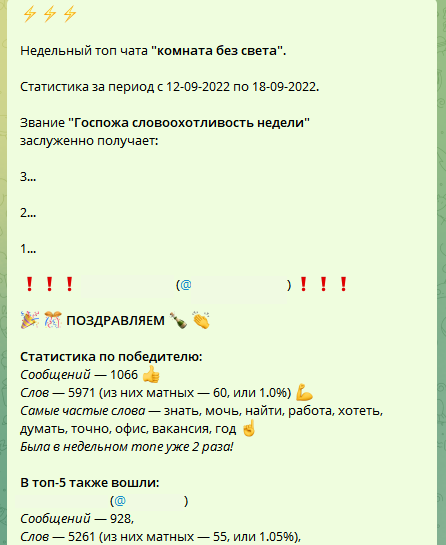